# Solving the Permuted Sequential MNIST (psMNIST) Task

The psMNIST (Permuted Sequential MNIST) task was introduced in 2015 by Le, Jaitly, and Hinton ([see paper](https://arxiv.org/pdf/1504.00941.pdf)). Similar to Sequential MNIST, the psMNIST task has the model process images, which correspond to handwritten digits, as a sequence of 784 pixels (28x28). The model then guesses the digit on the 785th timestep. However, psMNIST also applies a fixed permutation to the Sequential MNIST dataset to test the model's ability to learn on more complex data.

The following notebook uses NengoLMU layers inside a simple TensorFlow model to showcase the accuracy and efficiency that is producible using these novel cells. Currently, NengoLMU is state of the art for this task ([see paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf)).

In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

from lmu import LMUCell

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

## Step 1: Loading and Formatting the Dataset

First we set a seed to ensure this example is reproducible. Then, using that seed we generate a `RandomState`, which we use for fixed permutation of the data.

In [2]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

We now obtain the standard MNIST dataset of handwritten digits from `tf.keras.datasets`.

In [3]:
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

10969088/11490434 [===========================>..] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


We then normalize the pixel values by dividing by 255, as the current range of values is between 0-255. The image displayed below shows a grayscale version of a sample in the dataset. This is the type of data used for the standard MNIST task.

Text(0.5, 1.0, 'Image represents 5')

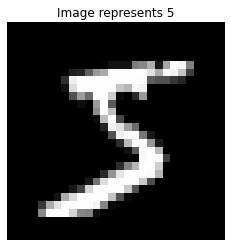

In [4]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis('off')
plt.title("Image represents " + str(train_labels[0]))

Here we flatten the images into sequences. To do this, we must reshape our dataset. The first dimension represents the number of samples our dataset has, which we keep the same. We want to transform each sample into a column vector, and to do so we make the second and third dimensions -1 and 1, respectively, leveraging a standard `numpy` trick specifically used for converting multi-dimensional data into column vectors. The image displayed below shows the result of this flattening process, and is an example of the type of data that is used in the Sequential MNIST task. Note that there is still a fair amount of structure remaining in the image.

Text(0.5, 1.0, 'Image represents 5')

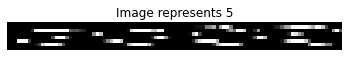

In [5]:
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis('off')
plt.title("Image represents " + str(train_labels[0]))

Finally, we apply a fixed permutation on the training and testing dataset. This essentially shuffles the pixels of the image sequences in a consistent way, allowing for images of the same digit to still be similar, but disabling the convenience of edges and contours for easy digit inference.

We can see, from the image below, that the fixed permutation applied to the image has evenly distributed the pixels across the entire sequence. This makes the task much more difficult as it makes it necessary for the model to process the entire input sequence to accurately predict what the digit is. We now have our data for the Permuted Sequential MNIST (psMNIST) task.

Text(0.5, 1.0, 'Image represents 5')

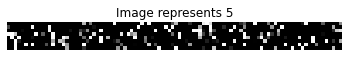

In [6]:
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis('off')
plt.title("Image represents " + str(train_labels[0]))

We allocate the first 50,000 training images for training, and the remaining 10,000 for validation. We can print out the shapes of these datasets to ensure we did all these steps correctly.

In [7]:
X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print("Training inputs shape: " + str(X_train.shape)
      + ", Training targets shape: " + str(Y_train.shape))
print("Validation inputs shape: " + str(X_valid.shape)
      + ", Validation targets shape: " + str(Y_valid.shape))
print("Testing inputs shape: " + str(X_test.shape)
      + ", Testing targets shape: " + str(Y_test.shape))

Training inputs shape: (50000, 784, 1), Training targets shape: (50000,)
Validation inputs shape: (10000, 784, 1), Validation targets shape: (10000,)
Testing inputs shape: (10000, 784, 1), Testing targets shape: (10000,)


## Step 2: Defining the Model

Our model uses 212 `units` and an `order` of 256 dimensions for the memory, maintaining `units` + `order` = 468 variables in memory between time-steps. These numbers were chosen primarily to have a comparable number of internal variables to the models that were being compared against in the [paper](https://arxiv.org/pdf/1504.00941.pdf).

The hidden state is projected to an output softmax layer. We set `theta` to 784 (the number of pixels in each sequence), and initialize the hidden and memory encoders, and input and hidden kernels to 0, in order to test the ability of the network to learn these parameters.

In [8]:
n_pixels = 28 ** 2


def lmu_layer(**kwargs):
    return RNN(
        LMUCell(
            units=212,
            order=256,
            theta=n_pixels,
            input_encoders_initializer=Constant(1),
            hidden_encoders_initializer=Constant(0),
            memory_encoders_initializer=Constant(0),
            input_kernel_initializer=Constant(0),
            hidden_kernel_initializer=Constant(0),
            memory_kernel_initializer="glorot_normal",
        ),
        return_sequences=False,
        **kwargs
    )


model = Sequential()
model.add(lmu_layer(input_shape=X_train.shape[1:],))  # (nr. of pixels, 1)
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 212)               165689    
_________________________________________________________________
dense (Dense)                (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


## Step 3: Training the Model

To train our model, we use a `batch_size` of 100, and train for 4 `epochs`, which is a far less than most other solutions to the psMNIST task. We could train for more epochs if we wished to fine-tune performance, but that is not necessary for the purposes of this example. We also create a `ModelCheckpoint` callback that saves the weights of the model to a file after each epoch.

The time required for this to run is tracked using the `time` library. Training may take a long time to complete, and to save time, this example uses pre-trained weights. To train the model from scratch, simply change the `do_training` variable to `True` before running any more code.

In [9]:
do_training = False
batch_size = 100
epochs = 4
t = time.time()

fname = "./psMNIST-standard.hdf5"
callbacks = [
    ModelCheckpoint(filepath=fname, monitor="val_loss", verbose=1, save_best_only=True),
]

if do_training:
    result = model.fit(
        X_train,
        to_categorical(Y_train),
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, to_categorical(Y_valid)),
        callbacks=callbacks,
    )

    print("Took {:.2f} min".format((time.time() - t) / 60))

## Step 4: Plotting Learning

Now we plot the result of the above training uing `matplotlib` functions. Here we plot the accuracy for the training and validation across the 4 epochs. Note that the loss can sometimes explode after enough epochs. As a result, we need to query the epoch that produced the minimum loss using `np.argmin()`.

If you are running a pretrained version of this model, as is displayed here, a saved image file representing the learning of the pretrianed model is being displayed.

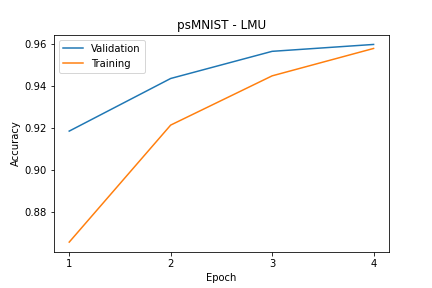

In [10]:
if do_training:
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("psMNIST - LMU")
    plt.xticks(np.arange(4), np.arange(1, 5))
    plt.savefig("psMNIST-LMU Learning.png")
    
    val_loss_min = np.argmin(result.history["val_loss"])
    print("Validation Accuracy: "
          + str(round(result.history["val_accuracy"][val_loss_min] * 100, 2)) + "%")

else:
    display(Image(filename='psMNIST-LMU Learning.png'))

## Step 5: Testing the Model

In the case where we want to use a pretrained model, we load the weights saved to file here. If we do train, this simply overwrites the model with the same weights. Once loaded, we test the model on our testing dataset.

In [11]:
model.load_weights(fname)
accuracy = model.evaluate(X_test, to_categorical(Y_test))[1] * 100
print("Testing accuracy: " + str(round(accuracy, 2)) + "%")

  1/313 [..............................] - ETA: 0s - loss: 0.0878 - accuracy: 0.9688

  2/313 [..............................] - ETA: 39s - loss: 0.0614 - accuracy: 0.9844

  3/313 [..............................] - ETA: 52s - loss: 0.0493 - accuracy: 0.9896

  4/313 [..............................] - ETA: 59s - loss: 0.0500 - accuracy: 0.9844

  5/313 [..............................] - ETA: 1:02 - loss: 0.0506 - accuracy: 0.9875

  6/313 [..............................] - ETA: 1:04 - loss: 0.0479 - accuracy: 0.9896

  7/313 [..............................] - ETA: 1:06 - loss: 0.0450 - accuracy: 0.9911

  8/313 [..............................] - ETA: 1:08 - loss: 0.0671 - accuracy: 0.9805

  9/313 [..............................] - ETA: 1:09 - loss: 0.0712 - accuracy: 0.9792

 10/313 [..............................] - ETA: 1:10 - loss: 0.0715 - accuracy: 0.9812

 11/313 [>.............................] - ETA: 1:10 - loss: 0.0873 - accuracy: 0.9744

 12/313 [>.............................] - ETA: 1:10 - loss: 0.0949 - accuracy: 0.9740

 13/313 [>.............................] - ETA: 1:10 - loss: 0.0966 - accuracy: 0.9736

 14/313 [>.............................] - ETA: 1:11 - loss: 0.1021 - accuracy: 0.9710

 15/313 [>.............................] - ETA: 1:11 - loss: 0.1039 - accuracy: 0.9708

 16/313 [>.............................] - ETA: 1:11 - loss: 0.1094 - accuracy: 0.9648

 17/313 [>.............................] - ETA: 1:11 - loss: 0.1046 - accuracy: 0.9669

 18/313 [>.............................] - ETA: 1:11 - loss: 0.1066 - accuracy: 0.9670

 19/313 [>.............................] - ETA: 1:11 - loss: 0.1096 - accuracy: 0.9655

 20/313 [>.............................] - ETA: 1:10 - loss: 0.1177 - accuracy: 0.9609

 21/313 [=>............................] - ETA: 1:10 - loss: 0.1174 - accuracy: 0.9613

 22/313 [=>............................] - ETA: 1:10 - loss: 0.1173 - accuracy: 0.9602

 23/313 [=>............................] - ETA: 1:10 - loss: 0.1221 - accuracy: 0.9592

 24/313 [=>............................] - ETA: 1:10 - loss: 0.1204 - accuracy: 0.9596

 25/313 [=>............................] - ETA: 1:10 - loss: 0.1171 - accuracy: 0.9613

 26/313 [=>............................] - ETA: 1:10 - loss: 0.1142 - accuracy: 0.9627

 27/313 [=>............................] - ETA: 1:10 - loss: 0.1166 - accuracy: 0.9618

 28/313 [=>............................] - ETA: 1:10 - loss: 0.1170 - accuracy: 0.9609

 29/313 [=>............................] - ETA: 1:09 - loss: 0.1182 - accuracy: 0.9612

 30/313 [=>............................] - ETA: 1:09 - loss: 0.1235 - accuracy: 0.9583

 31/313 [=>............................] - ETA: 1:09 - loss: 0.1234 - accuracy: 0.9587

 32/313 [==>...........................] - ETA: 1:09 - loss: 0.1278 - accuracy: 0.9570

 33/313 [==>...........................] - ETA: 1:09 - loss: 0.1302 - accuracy: 0.9564

 34/313 [==>...........................] - ETA: 1:08 - loss: 0.1305 - accuracy: 0.9559

 35/313 [==>...........................] - ETA: 1:08 - loss: 0.1356 - accuracy: 0.9554

 36/313 [==>...........................] - ETA: 1:08 - loss: 0.1351 - accuracy: 0.9557

 37/313 [==>...........................] - ETA: 1:08 - loss: 0.1365 - accuracy: 0.9544

 38/313 [==>...........................] - ETA: 1:08 - loss: 0.1354 - accuracy: 0.9556

 39/313 [==>...........................] - ETA: 1:07 - loss: 0.1455 - accuracy: 0.9535

 40/313 [==>...........................] - ETA: 1:07 - loss: 0.1502 - accuracy: 0.9523

 41/313 [==>...........................] - ETA: 1:07 - loss: 0.1515 - accuracy: 0.9520

 42/313 [===>..........................] - ETA: 1:07 - loss: 0.1568 - accuracy: 0.9509

 43/313 [===>..........................] - ETA: 1:07 - loss: 0.1546 - accuracy: 0.9513

 44/313 [===>..........................] - ETA: 1:06 - loss: 0.1565 - accuracy: 0.9503

 45/313 [===>..........................] - ETA: 1:06 - loss: 0.1575 - accuracy: 0.9486

 46/313 [===>..........................] - ETA: 1:06 - loss: 0.1569 - accuracy: 0.9490

 47/313 [===>..........................] - ETA: 1:06 - loss: 0.1601 - accuracy: 0.9488

 48/313 [===>..........................] - ETA: 1:05 - loss: 0.1611 - accuracy: 0.9479

 49/313 [===>..........................] - ETA: 1:05 - loss: 0.1655 - accuracy: 0.9471

 50/313 [===>..........................] - ETA: 1:05 - loss: 0.1660 - accuracy: 0.9469

 51/313 [===>..........................] - ETA: 1:05 - loss: 0.1677 - accuracy: 0.9467

 52/313 [===>..........................] - ETA: 1:05 - loss: 0.1682 - accuracy: 0.9471

 53/313 [====>.........................] - ETA: 1:04 - loss: 0.1698 - accuracy: 0.9469

 54/313 [====>.........................] - ETA: 1:04 - loss: 0.1701 - accuracy: 0.9468

 55/313 [====>.........................] - ETA: 1:04 - loss: 0.1746 - accuracy: 0.9455

 56/313 [====>.........................] - ETA: 1:04 - loss: 0.1769 - accuracy: 0.9459

 57/313 [====>.........................] - ETA: 1:03 - loss: 0.1746 - accuracy: 0.9468

 58/313 [====>.........................] - ETA: 1:03 - loss: 0.1731 - accuracy: 0.9477

 59/313 [====>.........................] - ETA: 1:03 - loss: 0.1727 - accuracy: 0.9476

 60/313 [====>.........................] - ETA: 1:03 - loss: 0.1727 - accuracy: 0.9479

 61/313 [====>.........................] - ETA: 1:02 - loss: 0.1733 - accuracy: 0.9477

 62/313 [====>.........................] - ETA: 1:02 - loss: 0.1751 - accuracy: 0.9466

 63/313 [=====>........................] - ETA: 1:02 - loss: 0.1751 - accuracy: 0.9459

 64/313 [=====>........................] - ETA: 1:02 - loss: 0.1777 - accuracy: 0.9448

 65/313 [=====>........................] - ETA: 1:01 - loss: 0.1781 - accuracy: 0.9447

 66/313 [=====>........................] - ETA: 1:01 - loss: 0.1821 - accuracy: 0.9441

 67/313 [=====>........................] - ETA: 1:01 - loss: 0.1862 - accuracy: 0.9431

 68/313 [=====>........................] - ETA: 1:01 - loss: 0.1842 - accuracy: 0.9439

 69/313 [=====>........................] - ETA: 1:00 - loss: 0.1832 - accuracy: 0.9443

 70/313 [=====>........................] - ETA: 1:00 - loss: 0.1816 - accuracy: 0.9451

 71/313 [=====>........................] - ETA: 1:00 - loss: 0.1800 - accuracy: 0.9454

 72/313 [=====>........................] - ETA: 1:00 - loss: 0.1830 - accuracy: 0.9449

 73/313 [=====>........................] - ETA: 59s - loss: 0.1830 - accuracy: 0.9443 

 74/313 [======>.......................] - ETA: 59s - loss: 0.1814 - accuracy: 0.9447

 75/313 [======>.......................] - ETA: 59s - loss: 0.1821 - accuracy: 0.9446

 76/313 [======>.......................] - ETA: 59s - loss: 0.1821 - accuracy: 0.9441

 77/313 [======>.......................] - ETA: 59s - loss: 0.1822 - accuracy: 0.9440

 78/313 [======>.......................] - ETA: 58s - loss: 0.1816 - accuracy: 0.9443

 79/313 [======>.......................] - ETA: 58s - loss: 0.1807 - accuracy: 0.9446

 80/313 [======>.......................] - ETA: 58s - loss: 0.1803 - accuracy: 0.9445

 81/313 [======>.......................] - ETA: 58s - loss: 0.1802 - accuracy: 0.9444

 82/313 [======>.......................] - ETA: 57s - loss: 0.1837 - accuracy: 0.9440

 83/313 [======>.......................] - ETA: 57s - loss: 0.1863 - accuracy: 0.9435

 84/313 [=======>......................] - ETA: 57s - loss: 0.1846 - accuracy: 0.9442

 85/313 [=======>......................] - ETA: 57s - loss: 0.1829 - accuracy: 0.9449

 86/313 [=======>......................] - ETA: 56s - loss: 0.1814 - accuracy: 0.9455

 87/313 [=======>......................] - ETA: 56s - loss: 0.1801 - accuracy: 0.9461

 88/313 [=======>......................] - ETA: 56s - loss: 0.1786 - accuracy: 0.9464

 89/313 [=======>......................] - ETA: 56s - loss: 0.1772 - accuracy: 0.9466

 90/313 [=======>......................] - ETA: 55s - loss: 0.1769 - accuracy: 0.9465

 91/313 [=======>......................] - ETA: 55s - loss: 0.1768 - accuracy: 0.9464

 92/313 [=======>......................] - ETA: 55s - loss: 0.1779 - accuracy: 0.9457

 93/313 [=======>......................] - ETA: 55s - loss: 0.1770 - accuracy: 0.9459

 94/313 [========>.....................] - ETA: 54s - loss: 0.1765 - accuracy: 0.9461

 95/313 [========>.....................] - ETA: 54s - loss: 0.1749 - accuracy: 0.9467

 96/313 [========>.....................] - ETA: 54s - loss: 0.1738 - accuracy: 0.9469

 97/313 [========>.....................] - ETA: 54s - loss: 0.1740 - accuracy: 0.9468

 98/313 [========>.....................] - ETA: 53s - loss: 0.1741 - accuracy: 0.9467

 99/313 [========>.....................] - ETA: 53s - loss: 0.1737 - accuracy: 0.9470

100/313 [========>.....................] - ETA: 53s - loss: 0.1726 - accuracy: 0.9475

101/313 [========>.....................] - ETA: 53s - loss: 0.1728 - accuracy: 0.9474

102/313 [========>.....................] - ETA: 52s - loss: 0.1718 - accuracy: 0.9476

103/313 [========>.....................] - ETA: 52s - loss: 0.1709 - accuracy: 0.9481

104/313 [========>.....................] - ETA: 52s - loss: 0.1694 - accuracy: 0.9486

105/313 [=========>....................] - ETA: 52s - loss: 0.1691 - accuracy: 0.9488

106/313 [=========>....................] - ETA: 51s - loss: 0.1695 - accuracy: 0.9484

107/313 [=========>....................] - ETA: 51s - loss: 0.1693 - accuracy: 0.9480

108/313 [=========>....................] - ETA: 51s - loss: 0.1683 - accuracy: 0.9485

109/313 [=========>....................] - ETA: 51s - loss: 0.1669 - accuracy: 0.9490

110/313 [=========>....................] - ETA: 50s - loss: 0.1667 - accuracy: 0.9489

111/313 [=========>....................] - ETA: 50s - loss: 0.1673 - accuracy: 0.9488

112/313 [=========>....................] - ETA: 50s - loss: 0.1674 - accuracy: 0.9484

113/313 [=========>....................] - ETA: 50s - loss: 0.1672 - accuracy: 0.9483

114/313 [=========>....................] - ETA: 49s - loss: 0.1662 - accuracy: 0.9487

115/313 [==========>...................] - ETA: 49s - loss: 0.1657 - accuracy: 0.9486

116/313 [==========>...................] - ETA: 49s - loss: 0.1655 - accuracy: 0.9488

117/313 [==========>...................] - ETA: 49s - loss: 0.1660 - accuracy: 0.9485

118/313 [==========>...................] - ETA: 48s - loss: 0.1673 - accuracy: 0.9481

119/313 [==========>...................] - ETA: 48s - loss: 0.1676 - accuracy: 0.9477

120/313 [==========>...................] - ETA: 48s - loss: 0.1705 - accuracy: 0.9469

121/313 [==========>...................] - ETA: 48s - loss: 0.1727 - accuracy: 0.9460

122/313 [==========>...................] - ETA: 47s - loss: 0.1729 - accuracy: 0.9460

123/313 [==========>...................] - ETA: 47s - loss: 0.1732 - accuracy: 0.9459

124/313 [==========>...................] - ETA: 47s - loss: 0.1737 - accuracy: 0.9458

125/313 [==========>...................] - ETA: 47s - loss: 0.1741 - accuracy: 0.9455

126/313 [===========>..................] - ETA: 46s - loss: 0.1734 - accuracy: 0.9457

127/313 [===========>..................] - ETA: 46s - loss: 0.1728 - accuracy: 0.9454

128/313 [===========>..................] - ETA: 46s - loss: 0.1752 - accuracy: 0.9448

129/313 [===========>..................] - ETA: 46s - loss: 0.1742 - accuracy: 0.9453

130/313 [===========>..................] - ETA: 45s - loss: 0.1745 - accuracy: 0.9450

131/313 [===========>..................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9449

132/313 [===========>..................] - ETA: 45s - loss: 0.1753 - accuracy: 0.9446

133/313 [===========>..................] - ETA: 45s - loss: 0.1770 - accuracy: 0.9443

134/313 [===========>..................] - ETA: 44s - loss: 0.1764 - accuracy: 0.9445

135/313 [===========>..................] - ETA: 44s - loss: 0.1789 - accuracy: 0.9442

136/313 [============>.................] - ETA: 44s - loss: 0.1783 - accuracy: 0.9446

137/313 [============>.................] - ETA: 44s - loss: 0.1788 - accuracy: 0.9441

138/313 [============>.................] - ETA: 43s - loss: 0.1777 - accuracy: 0.9445

139/313 [============>.................] - ETA: 43s - loss: 0.1775 - accuracy: 0.9445

140/313 [============>.................] - ETA: 43s - loss: 0.1765 - accuracy: 0.9449

141/313 [============>.................] - ETA: 43s - loss: 0.1768 - accuracy: 0.9448

142/313 [============>.................] - ETA: 43s - loss: 0.1768 - accuracy: 0.9448

143/313 [============>.................] - ETA: 42s - loss: 0.1767 - accuracy: 0.9445

144/313 [============>.................] - ETA: 42s - loss: 0.1762 - accuracy: 0.9447

145/313 [============>.................] - ETA: 42s - loss: 0.1761 - accuracy: 0.9446

146/313 [============>.................] - ETA: 42s - loss: 0.1753 - accuracy: 0.9448

147/313 [=============>................] - ETA: 41s - loss: 0.1748 - accuracy: 0.9449

148/313 [=============>................] - ETA: 41s - loss: 0.1743 - accuracy: 0.9451

149/313 [=============>................] - ETA: 41s - loss: 0.1741 - accuracy: 0.9453

150/313 [=============>................] - ETA: 41s - loss: 0.1731 - accuracy: 0.9456

151/313 [=============>................] - ETA: 40s - loss: 0.1748 - accuracy: 0.9452

152/313 [=============>................] - ETA: 40s - loss: 0.1739 - accuracy: 0.9455

153/313 [=============>................] - ETA: 40s - loss: 0.1753 - accuracy: 0.9451

154/313 [=============>................] - ETA: 40s - loss: 0.1744 - accuracy: 0.9454

155/313 [=============>................] - ETA: 39s - loss: 0.1756 - accuracy: 0.9448

156/313 [=============>................] - ETA: 39s - loss: 0.1758 - accuracy: 0.9447

157/313 [==============>...............] - ETA: 39s - loss: 0.1753 - accuracy: 0.9449

158/313 [==============>...............] - ETA: 39s - loss: 0.1743 - accuracy: 0.9452

159/313 [==============>...............] - ETA: 38s - loss: 0.1735 - accuracy: 0.9456

160/313 [==============>...............] - ETA: 38s - loss: 0.1725 - accuracy: 0.9459

161/313 [==============>...............] - ETA: 38s - loss: 0.1719 - accuracy: 0.9460

162/313 [==============>...............] - ETA: 38s - loss: 0.1718 - accuracy: 0.9462

163/313 [==============>...............] - ETA: 37s - loss: 0.1712 - accuracy: 0.9463

164/313 [==============>...............] - ETA: 37s - loss: 0.1702 - accuracy: 0.9466

165/313 [==============>...............] - ETA: 37s - loss: 0.1694 - accuracy: 0.9468

166/313 [==============>...............] - ETA: 37s - loss: 0.1684 - accuracy: 0.9471

167/313 [===============>..............] - ETA: 36s - loss: 0.1685 - accuracy: 0.9472

168/313 [===============>..............] - ETA: 36s - loss: 0.1675 - accuracy: 0.9475

169/313 [===============>..............] - ETA: 36s - loss: 0.1666 - accuracy: 0.9479

170/313 [===============>..............] - ETA: 36s - loss: 0.1657 - accuracy: 0.9482

171/313 [===============>..............] - ETA: 35s - loss: 0.1653 - accuracy: 0.9483

172/313 [===============>..............] - ETA: 35s - loss: 0.1644 - accuracy: 0.9486

173/313 [===============>..............] - ETA: 35s - loss: 0.1637 - accuracy: 0.9489

174/313 [===============>..............] - ETA: 35s - loss: 0.1629 - accuracy: 0.9492

175/313 [===============>..............] - ETA: 34s - loss: 0.1623 - accuracy: 0.9493

176/313 [===============>..............] - ETA: 34s - loss: 0.1616 - accuracy: 0.9496

177/313 [===============>..............] - ETA: 34s - loss: 0.1625 - accuracy: 0.9495

178/313 [================>.............] - ETA: 34s - loss: 0.1620 - accuracy: 0.9494

179/313 [================>.............] - ETA: 33s - loss: 0.1613 - accuracy: 0.9497

180/313 [================>.............] - ETA: 33s - loss: 0.1626 - accuracy: 0.9493

181/313 [================>.............] - ETA: 33s - loss: 0.1618 - accuracy: 0.9496

182/313 [================>.............] - ETA: 32s - loss: 0.1612 - accuracy: 0.9497

183/313 [================>.............] - ETA: 32s - loss: 0.1609 - accuracy: 0.9498

184/313 [================>.............] - ETA: 32s - loss: 0.1609 - accuracy: 0.9499

185/313 [================>.............] - ETA: 32s - loss: 0.1619 - accuracy: 0.9497

186/313 [================>.............] - ETA: 31s - loss: 0.1628 - accuracy: 0.9493

187/313 [================>.............] - ETA: 31s - loss: 0.1658 - accuracy: 0.9485

188/313 [=================>............] - ETA: 31s - loss: 0.1655 - accuracy: 0.9486

189/313 [=================>............] - ETA: 31s - loss: 0.1667 - accuracy: 0.9482

190/313 [=================>............] - ETA: 30s - loss: 0.1671 - accuracy: 0.9482

191/313 [=================>............] - ETA: 30s - loss: 0.1674 - accuracy: 0.9481

192/313 [=================>............] - ETA: 30s - loss: 0.1667 - accuracy: 0.9484

193/313 [=================>............] - ETA: 30s - loss: 0.1686 - accuracy: 0.9480

194/313 [=================>............] - ETA: 29s - loss: 0.1678 - accuracy: 0.9483

195/313 [=================>............] - ETA: 29s - loss: 0.1670 - accuracy: 0.9486

196/313 [=================>............] - ETA: 29s - loss: 0.1661 - accuracy: 0.9488

197/313 [=================>............] - ETA: 29s - loss: 0.1653 - accuracy: 0.9491

198/313 [=================>............] - ETA: 28s - loss: 0.1645 - accuracy: 0.9493

199/313 [==================>...........] - ETA: 28s - loss: 0.1639 - accuracy: 0.9494

200/313 [==================>...........] - ETA: 28s - loss: 0.1635 - accuracy: 0.9495

201/313 [==================>...........] - ETA: 28s - loss: 0.1632 - accuracy: 0.9495

202/313 [==================>...........] - ETA: 27s - loss: 0.1624 - accuracy: 0.9497

203/313 [==================>...........] - ETA: 27s - loss: 0.1618 - accuracy: 0.9500

204/313 [==================>...........] - ETA: 27s - loss: 0.1619 - accuracy: 0.9501

205/313 [==================>...........] - ETA: 27s - loss: 0.1613 - accuracy: 0.9503

206/313 [==================>...........] - ETA: 26s - loss: 0.1621 - accuracy: 0.9499

207/313 [==================>...........] - ETA: 26s - loss: 0.1630 - accuracy: 0.9497

208/313 [==================>...........] - ETA: 26s - loss: 0.1636 - accuracy: 0.9497

209/313 [===================>..........] - ETA: 26s - loss: 0.1633 - accuracy: 0.9498

210/313 [===================>..........] - ETA: 25s - loss: 0.1628 - accuracy: 0.9499

211/313 [===================>..........] - ETA: 25s - loss: 0.1627 - accuracy: 0.9498

212/313 [===================>..........] - ETA: 25s - loss: 0.1628 - accuracy: 0.9494

213/313 [===================>..........] - ETA: 25s - loss: 0.1627 - accuracy: 0.9494

214/313 [===================>..........] - ETA: 24s - loss: 0.1621 - accuracy: 0.9495

215/313 [===================>..........] - ETA: 24s - loss: 0.1615 - accuracy: 0.9497

216/313 [===================>..........] - ETA: 24s - loss: 0.1610 - accuracy: 0.9499

217/313 [===================>..........] - ETA: 24s - loss: 0.1607 - accuracy: 0.9500

218/313 [===================>..........] - ETA: 23s - loss: 0.1601 - accuracy: 0.9503

219/313 [===================>..........] - ETA: 23s - loss: 0.1598 - accuracy: 0.9503

220/313 [====================>.........] - ETA: 23s - loss: 0.1592 - accuracy: 0.9506

221/313 [====================>.........] - ETA: 23s - loss: 0.1586 - accuracy: 0.9508

222/313 [====================>.........] - ETA: 22s - loss: 0.1579 - accuracy: 0.9510

223/313 [====================>.........] - ETA: 22s - loss: 0.1573 - accuracy: 0.9512

224/313 [====================>.........] - ETA: 22s - loss: 0.1567 - accuracy: 0.9515

225/313 [====================>.........] - ETA: 22s - loss: 0.1560 - accuracy: 0.9517

226/313 [====================>.........] - ETA: 21s - loss: 0.1556 - accuracy: 0.9517

227/313 [====================>.........] - ETA: 21s - loss: 0.1553 - accuracy: 0.9518

228/313 [====================>.........] - ETA: 21s - loss: 0.1547 - accuracy: 0.9520

229/313 [====================>.........] - ETA: 21s - loss: 0.1540 - accuracy: 0.9522

230/313 [=====================>........] - ETA: 20s - loss: 0.1536 - accuracy: 0.9524

231/313 [=====================>........] - ETA: 20s - loss: 0.1530 - accuracy: 0.9527

232/313 [=====================>........] - ETA: 20s - loss: 0.1525 - accuracy: 0.9529

233/313 [=====================>........] - ETA: 20s - loss: 0.1524 - accuracy: 0.9528

234/313 [=====================>........] - ETA: 19s - loss: 0.1520 - accuracy: 0.9530

235/313 [=====================>........] - ETA: 19s - loss: 0.1515 - accuracy: 0.9532

236/313 [=====================>........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9533

237/313 [=====================>........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9535

238/313 [=====================>........] - ETA: 18s - loss: 0.1500 - accuracy: 0.9535

239/313 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9537

240/313 [======================>.......] - ETA: 18s - loss: 0.1491 - accuracy: 0.9539

241/313 [======================>.......] - ETA: 18s - loss: 0.1485 - accuracy: 0.9541

242/313 [======================>.......] - ETA: 17s - loss: 0.1481 - accuracy: 0.9542

243/313 [======================>.......] - ETA: 17s - loss: 0.1475 - accuracy: 0.9543

244/313 [======================>.......] - ETA: 17s - loss: 0.1471 - accuracy: 0.9545

245/313 [======================>.......] - ETA: 17s - loss: 0.1467 - accuracy: 0.9546

246/313 [======================>.......] - ETA: 16s - loss: 0.1464 - accuracy: 0.9548

247/313 [======================>.......] - ETA: 16s - loss: 0.1461 - accuracy: 0.9548

248/313 [======================>.......] - ETA: 16s - loss: 0.1458 - accuracy: 0.9550

249/313 [======================>.......] - ETA: 16s - loss: 0.1455 - accuracy: 0.9551

250/313 [======================>.......] - ETA: 15s - loss: 0.1450 - accuracy: 0.9553

251/313 [=======================>......] - ETA: 15s - loss: 0.1446 - accuracy: 0.9553

252/313 [=======================>......] - ETA: 15s - loss: 0.1445 - accuracy: 0.9552

253/313 [=======================>......] - ETA: 15s - loss: 0.1445 - accuracy: 0.9552

254/313 [=======================>......] - ETA: 14s - loss: 0.1440 - accuracy: 0.9553

255/313 [=======================>......] - ETA: 14s - loss: 0.1435 - accuracy: 0.9555

256/313 [=======================>......] - ETA: 14s - loss: 0.1432 - accuracy: 0.9556

257/313 [=======================>......] - ETA: 14s - loss: 0.1427 - accuracy: 0.9557

258/313 [=======================>......] - ETA: 13s - loss: 0.1424 - accuracy: 0.9559

259/313 [=======================>......] - ETA: 13s - loss: 0.1422 - accuracy: 0.9560

260/313 [=======================>......] - ETA: 13s - loss: 0.1423 - accuracy: 0.9558

261/313 [========================>.....] - ETA: 13s - loss: 0.1424 - accuracy: 0.9556

262/313 [========================>.....] - ETA: 12s - loss: 0.1420 - accuracy: 0.9556

263/313 [========================>.....] - ETA: 12s - loss: 0.1419 - accuracy: 0.9556

264/313 [========================>.....] - ETA: 12s - loss: 0.1415 - accuracy: 0.9557

265/313 [========================>.....] - ETA: 12s - loss: 0.1410 - accuracy: 0.9559

266/313 [========================>.....] - ETA: 11s - loss: 0.1407 - accuracy: 0.9561

267/313 [========================>.....] - ETA: 11s - loss: 0.1409 - accuracy: 0.9559

268/313 [========================>.....] - ETA: 11s - loss: 0.1404 - accuracy: 0.9560

269/313 [========================>.....] - ETA: 11s - loss: 0.1399 - accuracy: 0.9562

270/313 [========================>.....] - ETA: 10s - loss: 0.1395 - accuracy: 0.9564

271/313 [========================>.....] - ETA: 10s - loss: 0.1390 - accuracy: 0.9565

272/313 [=========================>....] - ETA: 10s - loss: 0.1385 - accuracy: 0.9567

273/313 [=========================>....] - ETA: 10s - loss: 0.1380 - accuracy: 0.9568

274/313 [=========================>....] - ETA: 9s - loss: 0.1375 - accuracy: 0.9570 

275/313 [=========================>....] - ETA: 9s - loss: 0.1370 - accuracy: 0.9572

276/313 [=========================>....] - ETA: 9s - loss: 0.1365 - accuracy: 0.9573

277/313 [=========================>....] - ETA: 9s - loss: 0.1361 - accuracy: 0.9575

278/313 [=========================>....] - ETA: 8s - loss: 0.1356 - accuracy: 0.9576

279/313 [=========================>....] - ETA: 8s - loss: 0.1352 - accuracy: 0.9578

280/313 [=========================>....] - ETA: 8s - loss: 0.1347 - accuracy: 0.9579

281/313 [=========================>....] - ETA: 8s - loss: 0.1342 - accuracy: 0.9581

282/313 [==========================>...] - ETA: 7s - loss: 0.1352 - accuracy: 0.9579

283/313 [==========================>...] - ETA: 7s - loss: 0.1359 - accuracy: 0.9578

284/313 [==========================>...] - ETA: 7s - loss: 0.1355 - accuracy: 0.9580

285/313 [==========================>...] - ETA: 7s - loss: 0.1351 - accuracy: 0.9581

286/313 [==========================>...] - ETA: 6s - loss: 0.1347 - accuracy: 0.9583

287/313 [==========================>...] - ETA: 6s - loss: 0.1342 - accuracy: 0.9584

288/313 [==========================>...] - ETA: 6s - loss: 0.1338 - accuracy: 0.9586

289/313 [==========================>...] - ETA: 6s - loss: 0.1334 - accuracy: 0.9587

290/313 [==========================>...] - ETA: 5s - loss: 0.1330 - accuracy: 0.9588

291/313 [==========================>...] - ETA: 5s - loss: 0.1328 - accuracy: 0.9588

292/313 [==========================>...] - ETA: 5s - loss: 0.1324 - accuracy: 0.9589

293/313 [===========================>..] - ETA: 5s - loss: 0.1320 - accuracy: 0.9590

294/313 [===========================>..] - ETA: 4s - loss: 0.1317 - accuracy: 0.9592

295/313 [===========================>..] - ETA: 4s - loss: 0.1315 - accuracy: 0.9592

296/313 [===========================>..] - ETA: 4s - loss: 0.1311 - accuracy: 0.9594

297/313 [===========================>..] - ETA: 4s - loss: 0.1308 - accuracy: 0.9594

298/313 [===========================>..] - ETA: 3s - loss: 0.1307 - accuracy: 0.9594

299/313 [===========================>..] - ETA: 3s - loss: 0.1306 - accuracy: 0.9593

300/313 [===========================>..] - ETA: 3s - loss: 0.1305 - accuracy: 0.9594

301/313 [===========================>..] - ETA: 3s - loss: 0.1302 - accuracy: 0.9595

302/313 [===========================>..] - ETA: 2s - loss: 0.1308 - accuracy: 0.9593

303/313 [============================>.] - ETA: 2s - loss: 0.1315 - accuracy: 0.9592

304/313 [============================>.] - ETA: 2s - loss: 0.1324 - accuracy: 0.9588

305/313 [============================>.] - ETA: 2s - loss: 0.1335 - accuracy: 0.9585

306/313 [============================>.] - ETA: 1s - loss: 0.1348 - accuracy: 0.9581

307/313 [============================>.] - ETA: 1s - loss: 0.1353 - accuracy: 0.9580

308/313 [============================>.] - ETA: 1s - loss: 0.1353 - accuracy: 0.9579

309/313 [============================>.] - ETA: 1s - loss: 0.1353 - accuracy: 0.9577

310/313 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9576

311/313 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9575

312/313 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9573

313/313 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9574

313/313 [==============================] - 79s 253ms/step - loss: 0.1361 - accuracy: 0.9574


Testing accuracy: 95.74%
